In [1]:
# sys, file and nav packages:
# import os
import datetime as dt
# import csv
# import json

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as chartkwargs


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-04-01'
end_date ='2021-04-01'

# the city, lake and river bassin we are aggregating to
# the keys are column names in the survey data
levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}

# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# name of the output folder:
name_of_project = 'keyindicatorsexample'

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

## <span style="color:#008891">Key statistical indicators of beach litter survey results</span>

#### <span style="color:#008891">Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes</span>

The key indicators are common relationships used to provide insight to the most frequent questions using parameters that are taken directly from the survey data. The key indicators are relatively easy to calculate and interpret. In this section we explain the key indicators and use examples from the current data. 

#### <span style="color:#008891">A brief reminder of the survey method</span>

A survey is a collection of observations. The observations correspond to the objects that were removed and counted during the survey. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

Some locations are sampled monthly, other were only sampled once. The scope and size of the data for this example:

In [2]:
# name the data sources and where to find them
# the easiest is to put them in the resources/most_recent directory
# the extension default is resources/most_recent/
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_ranks.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",    
}

# define the methods to use for the .JSON and .csv files:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups = ac.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# format the date to timestamp and slice the data by start/end date
dfSurveys = ac.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = ac.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# make a map to the code descriptions
code_description_map = dfCodes.description

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = ac.PreprocessData(data,  dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# thats it! all the survey records with the independent variables attached and columns to group by
# date, location, (location, date), river bassin, water body, city, material, usage group, or object

# define the data set for this example:
trb = a_data.loc[a_data.river_bassin == levels['river_bassin']].copy()

# describe the data set:
num_obs = len(trb)
num_samps = len(trb.loc_date.unique())
num_obj = trb.quantity.sum()
num_locs = len(trb.location.unique())

# the city that we are looking at:
biel = trb[trb.city == levels['city']]

# samples at biel
biel_locd = biel.loc_date.unique()

# locations at biel
biel_loc = biel.location.unique()

# example data summary and keys
biel_t = biel.quantity.sum()
biel_fail = biel.loc[biel.quantity > 0]
biel_nfail = len(biel_fail.code.unique())

print(F"\nThis data is valid for all surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {trb.river_bassin.unique()}")
print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


This data is valid for all surveys between 2020-04-01 and 2021-04-01 from the following catchment areas:

  ['aare']

There are 28,288 observations from 128 surveys.

There were 12,875 objects collected.


### <span style="color:#008891">Indicators for the most frequent questions</span>

1. What do you find?
2. How often do you find it?
3. How much do you find?
4. What else do you find?
5. Where do you find the most?

These are important questions to answer. The survey results are a census of objects that were primarily washed up on the beach. This helps answer the question:


> **What are we likely to find at the beach?**

> **What are we likely to find in the water?**

The key indicators differ between regions and locations.  Which may mean that the extent and/or nature of the problem is different from one region to another.

The reliability of these indicators is based on the following assumptions:

1. The more trash there is on the ground the more a person is likely to find
2. The survey results represent the minimum amount of trash at that site²
3. The chance of finding any item is the same as finding any other item³


#### <span style="color:#008891">More information </span>

For information on a specific catchment area or a water feature see the notebook for that catchment area (or make one and send a pull request). For more information on the project visit https://www.plagespropres.ch/ .


¹ The EU guide on monitoring marine litter https://mcc.jrc.ec.europa.eu/documents/201702074014.pdfhttps://mcc.jrc.ec.europa.eu/documents/201702074014.pdf<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent and identically distributed : https://stats.stackexchange.com/questions/17391/what-are-i-i-d-random-variables


### <span style="color:#008891">Fail rate: likelihood of finding an object</span>

#### The fail rate is the number of times that an object was found divided by the number of surveys.

**What does it mean?** The fail rate describes the percent of times that a category was identified in relation to the amount of surveys conducted

> Use the fail rate to determine how frequently an object is found within a geographic range

> Use the fail rate to indentify objects that are found frequently but in low numbers

In [3]:
print("\nConsider the summary of the surveys conducted in Biel/Bienne:")
print(F"\nThere were { '{:,}'.format( biel_t)} objects removed and identified in the course of { len(biel_locd) } surveys taken from {len(biel_loc)} locations in Biel/Bienne.")
print(F"\nThe objects were placed in to the following {biel_nfail} of the {len(dfCodes)} possible categories:\n\n{biel_fail.code.unique()}\n")


Consider the summary of the surveys conducted in Biel/Bienne:

There were 3,067 objects removed and identified in the course of 16 surveys taken from 3 locations in Biel/Bienne.

The objects were placed in to the following 118 of the 260 possible categories:

['G117' 'G213' 'G73' 'G152' 'G24' 'G87' 'G159' 'G3' 'G905' 'G170' 'G33'
 'G101' 'G178' 'G38' 'G939' 'G115' 'G211' 'G67' 'G95' 'G148' 'G23' 'G79'
 'G156' 'G27' 'G901' 'G167' 'G31' 'G100' 'G177' 'G35' 'G922' 'G112' 'G200'
 'G50' 'G941' 'G143' 'G22' 'G78' 'G153' 'G25' 'G89' 'G165' 'G30' 'G175'
 'G34' 'G917' 'G106' 'G186' 'G48' 'G940' 'G908' 'G41' 'G923' 'G21' 'G70'
 'G942' 'G4' 'G28' 'G904' 'G37' 'G191' 'G928' 'G10' 'G135' 'G68' 'G98'
 'G32' 'G936' 'G133' 'G66' 'G125' 'G8' 'G103' 'G93' 'G91' 'G916' 'G155'
 'G142' 'G7' 'G208' 'G26' 'G198' 'G921' 'G76' 'G927' 'G12' 'G150' 'G59'
 'G914' 'G197' 'G930' 'G171' 'G53' 'G913' 'G118' 'G137' 'G161' 'G104'
 'G188' 'G75' 'G43' 'G71' 'G20' 'G49' 'G918' 'G210' 'G2' 'G203' 'G919'
 'G195' 'G158' 'G9

#### <span style="color:#008891">Calculate the fail rate per object category, for one city, lake and river basin</span>

The fail rate can be calculated for any lake, municipality or river bassin __provided you have a sufficient quantity of reliable data__. Biel/Bienne is a city on Bielersee in the Aare river bassin. There were multiple surveys from multiple locations within the river bassin.

**How much data is sufficient?** The data should cover the land use characteristics for the geographic and temporal scale appropriate to the area of study. Local authorities will have insight to land use characteristics that can greatly increase monitoring effiency. **How confident we are in the findings is directly related to the quality and the amount of data available**.

To calculate the fail rates for Biel, Bielersee and the Aare river basin we just add up the number of times a code was used and divide it by the number of surveys for the city, lake or river basin.

#### <span style="color:#008891">The 10 items identified the most often in Biel/Bienne</span>

Compare the fail-rates of the ten most common items from the 16 surveys in Biel to the fail-rates of those same items for Bielersee the Aare and all other river bassins

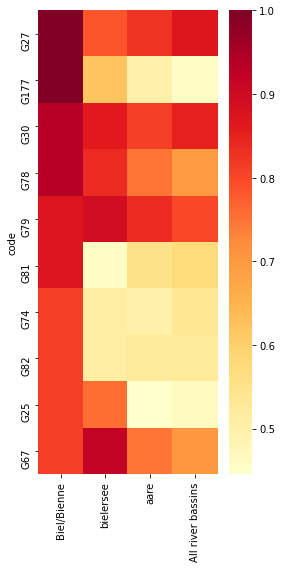

In [4]:
# this is a convenience function for the abundance class
# the fail rate needs to be recalculated at each aggregation level
fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code', )

# plot that
fig, ax = plt.subplots(figsize=(4,8))

sns.heatmap(fail_rates_df.sort_values(by="Biel/Bienne", ascending=False)[:10], cmap='YlOrRd', ax = ax)
        
plt.tight_layout()
plt.show()

With the exception of fragmented plastics and plastic sheeting the fail rate for the top ten items in Biel/Bienne was greater than the rest of the lake, the river bassin and nationally.

**The fail rate is not the probability of finding one object**, it is the most likely estimate (MLE) of the probability of finding one object. The MLE is the best estimate for the probability of a binomial variabe (the pass fail rate is a bimomial variable). A complete derivation of the MLE of the binomial variable is beyond the scope of this article but very easy to understand⁴. 

**With that the first two questions are answered:**

In [5]:
print("\nWhat do you find on the beach in Biel/Bienne?")
print(F"\nThere were {biel_nfail} categories that were identified at least one time:\n\n{biel_fail.code.unique()}\n")
print("\nHow often are those objects found?")
print(F"\nThe 10 objects that were identified the most frequently:\n\n{fail_rates_df.sort_values(by='Biel/Bienne', ascending=False)[:10]['Biel/Bienne']}\n")


What do you find on the beach in Biel/Bienne?

There were 118 categories that were identified at least one time:

['G117' 'G213' 'G73' 'G152' 'G24' 'G87' 'G159' 'G3' 'G905' 'G170' 'G33'
 'G101' 'G178' 'G38' 'G939' 'G115' 'G211' 'G67' 'G95' 'G148' 'G23' 'G79'
 'G156' 'G27' 'G901' 'G167' 'G31' 'G100' 'G177' 'G35' 'G922' 'G112' 'G200'
 'G50' 'G941' 'G143' 'G22' 'G78' 'G153' 'G25' 'G89' 'G165' 'G30' 'G175'
 'G34' 'G917' 'G106' 'G186' 'G48' 'G940' 'G908' 'G41' 'G923' 'G21' 'G70'
 'G942' 'G4' 'G28' 'G904' 'G37' 'G191' 'G928' 'G10' 'G135' 'G68' 'G98'
 'G32' 'G936' 'G133' 'G66' 'G125' 'G8' 'G103' 'G93' 'G91' 'G916' 'G155'
 'G142' 'G7' 'G208' 'G26' 'G198' 'G921' 'G76' 'G927' 'G12' 'G150' 'G59'
 'G914' 'G197' 'G930' 'G171' 'G53' 'G913' 'G118' 'G137' 'G161' 'G104'
 'G188' 'G75' 'G43' 'G71' 'G20' 'G49' 'G918' 'G210' 'G2' 'G203' 'G919'
 'G195' 'G158' 'G929' 'G64' 'G96' 'G204' 'G82' 'G81' 'G74']


How often are those objects found?

The 10 objects that were identified the most frequently:

code
G27

**Conclusion**: We now know what items were found the most often _and that tells us about what we may find at the next survey_ but we do not know how many of these objects were found at each survey. To do that we need to look at the quantity found as well as size of the survey.

⁴ A very simple explanation of the MLE for a binomial variable: https://www.youtube.com/watch?v=4KKV9yZCoM4

### <span style="color:#008891">Pieces per meter: How much do you find</span>

#### Pieces per meter is the number of objects found divided by the length of the shoreline surveyed.

**What does it mean?** Pieces per meter describes the quantiy of an object that was found for each meter of shoreline surveyed.

> Use pieces per meter to compare the magnitude of results between locations

> Use pieces per meter to identify zones of accumulation

_Why not use the surface area?_ The norm internationally is to report the results as quantity of objects per length of shoreline surveyed, usually 100 meters. You can use either one, however if you are looking for comparable data sets your choices may be limited if using the surface area is a requirement. The example here is given in pieces per meter.

#### <span style="color:#008891">Calculate the pieces per meter of the ten objects the most frequently identified at Biel/Bienne</span>

The pieces per meter (pcs_m) is calculated for each observation at the time the survey is submitted. This value can be taken directly from the survey results. The pcs_m value is not cumulative, therefore we need to use either the mean or the median value. Because we are interested in how many may be found at a survey we will use the median value for each object of the ten most identified objects in the city of Biel/Bienne.  


<br/><br />

#### **Pieces per meter:** How many objects were found within a defined distance

The pieces per meter ratio is the total number of objects found divided by the length in meters of the survey. This ratio is calculated for each record in the survey. Objects that were not identified durring a survey have a pcs/m ratio of 0.

_Pieces per meter is the number of objects found divided by the number of samples taken._

__what does it mean:__ The pcs-m ratio describes the average amount of an object you are likely to find if you mulitply pcs/m by the survey length

__how to use it:__ Objects with a high pcs/m ratio have a higher minimum value per survey (if they are found: see fail rate)

__Why is this is important?__ A high pcs/m ration indicates either proximity to a source or a zone of accumulation
<br/><br />

#### **% of total** The amount of an object relative to the other objects indeitififed

The percent of total describes the value of an object when all the other objects are considered.

__what does it mean:__ The % of total describes how much of the problem can be attributed to an object or group of objects

__how to use it:__ The % of total is the often the first indicator used to prioritize mitigation campaigns

__Why is this important:__ This helps define the problem at different levels
<br/><br />

## <span style="color:#008891">Description of survey results</span>

### <span style="color:#008891"> Total number of surveys and observations, total number of objects found, number of cities and total population concerned</span>

## <span style="color:#008891">The top ten objects identified</span>

In [6]:
# note all records where quantity is > 0
a_data['fail'] = a_data.quantity > 0
w_bassin_total = a_data.groupby('river_bassin').quantity.sum()

# get the list of codes by quantity
national_topten= a.code_totals.sort_values(ascending=False)

# take first ten records after sorting
national_topten_codes = national_topten.index[:10]

# grab the data from the survey results:
top_ten_national = a_data[a_data.code.isin(national_topten_codes)][['code', 'quantity', 'fail', 'pcs_m', 'loc_date']].copy()

# add descriptive and categorical variables:
top_ten_national['material'] = top_ten_national.code.map(lambda x: material_map.loc[x])
top_ten_national['description'] = top_ten_national.code.map(lambda x: desc_map.loc[x])


# agg the values from the survey data
# there is a convenience method for this
# the groups and the level where quantity is calculated:
groups = {'quantity_level':'code', 'columns':['code', 'description']}

# the columns to aggregate
aggs = {'pcs_m':'mean', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'}

# columns divided by other columns
rates = [
    {'rate_name':'fail rate','columns':{'this':'fail', 'over_that':'loc_date'}},
    {'rate_name':'% of total', 'columns':{'this':'quantity', 'over_that':'feature_total'}},
]

# product of two columns
products = [
     {'rate_name':'rating', 'columns':{'this':'pcs_m', 'times_that':'fail rate'}}    
]

# method that returns the project total total:
def get_the_project_total(x , adf):
    return  adf.quantity.sum()

# calculate the fail rate and % of total for each code:
top_ten_agg = ac.calculate_rates(top_ten_national, feature_total_map=get_the_project_total, feature_map=a_data,groups=groups, aggs=aggs, rates=rates, products=products)

# for display purposes make the description the index
top_ten_agg.set_index('description', inplace=True)
print(F"\nThe top ten objects are {round((top_ten_agg.quantity.sum()/num_obj)*100, 2)}% of all objects identified\n")

tt_agg = top_ten_agg[['quantity']].sort_values(by='quantity', ascending=False).round(2)
tt_agg

NameError: name 'material_map' is not defined

#### <span style="color:#008891">Survey results: consolidating object categories</span>

The top ten list gives a very high level summary of the survey results. Based entirely on the total amount of an object found. It is a good indicator of overall abundance of an object in the ecosystem. Using this method we can account for ~60% of objects identified and very quickly identify the most abundant objects.

The top ten list can be improved to account for a greater percentage of the objects found. Currently, polystyrene is present in three forms in the top ten list, extruded polystyrene and two size variants of expanded polystyrene. Fragmented plastics are also present twice in the top ten list. The survey method was designed to get a maximum amount of detail for each survey. Grouping like objects by size is a common way to differentiate observations.

Some of the objects in the top ten list that can be consolidated:

1. There are three objects that are made from expanded or extruded polystyrene
2. Fragmented plastics are present in two different size ranges.

By combining like objects or objects that have the same or similar origin the impact of that group can be better appreciated. When the foam and the fragmented plastics are combined, that liberates three new places in the top ten list. Foams replace cigarette ends as the most abundant (pcs/m and quantity) but cigarette ends still retain the title as most frequently found (fail rate). The top ten list now accounts for ~70% of the objects identified.

#### <span style="color:#008891"> There is more room at the top: a consolidated top ten list</span>

In [ ]:
fts = a_data.groupby(['river_bassin','big_group','loc_date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fts['fail'] = fts.quantity > 0

# assign a description to results:
def assign_descriptions(x, **kwargs):
    if x in kwargs['exclude']:
        data = x
    else:
        data = kwargs['som_keys'][x]
    return data


groups = {'quantity_level':'big_group', 'columns':['big_group']}

ftsx = ac.calculate_rates(fts, feature_total_map=get_the_project_total, feature_map=a_data,groups=groups, aggs=aggs, rates=rates, products=products)

bg_desc = ['foams', 'cigarette ends', 'frag plastic', 'snack wrapper', 'sheeting']
som_kwargs = dict(exclude=bg_desc, som_keys=desc_map)

ftsx['description'] = ftsx.big_group.map(lambda x: assign_descriptions(x, **som_kwargs))


ftsx = ftsx[['description','quantity', '% of total', 'pcs_m','fail rate']].set_index('description').sort_values(by='quantity', ascending=False)[:10].round(2)
print(F"\nThe consolidated top ten objects are {round((ftsx.quantity.sum()/num_obj)*100, 2)}% of all objects identified\n")
ftsx

The *fail rate* is a **key indicator** as well as *% of total* and *pieces per meter*. Each indicator can be used to understand different aspects of the survey results. 

#### <span style="color:#008891">Key indicators of the top ten objects</span>

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(5.4,8))

sns.heatmap(pd.DataFrame(ftsx['% of total']), ax = axs[0], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)
sns.heatmap(pd.DataFrame(ftsx['pcs_m']), ax = axs[1], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", yticklabels=False, cbar=False)
sns.heatmap(pd.DataFrame(ftsx['fail rate']), ax = axs[2], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", yticklabels=False, cbar=False)

for i in [0,1,2]:
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].xaxis.tick_top()
    axs[i].xaxis.set_label_position('top') 

plt.tight_layout()

plt.show()
plt.close()

#### Have a great day

This project was made possible by the Swiss federal office for the environment.

This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.

In [ ]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
print(F"\nProduced by: {author}\nDate: {today}\n\n{my_message}")